# Fermion Chain to Boson Chain

To properly work with Qutip we have to figure out how to incorporate fermions since there is no dedicated operator for that in this toolbox. There are however boson operators. Therefore **we can just use Jorda-Wigner transforms to express our fermionic operators (even with spins, we have to figure that one out) in terms of the JW string times a bosoni operator**. This is what we do here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from qutip import  *

In [2]:
def create_fermion_op(Nsites, bop):
    # create fermions from quspin bosons and JW strings
    # bop is the boson operator
    C_list = []
    for site_j in range(0, Nsites):
        # create the string
        JW_string = [identity(2)]*Nsites
        for l in range(0,site_j):
            JW_string[l] = (1j*np.pi*bop.dag()*bop).expm()
        JW_string[site_j] = bop
        # tensor product the string to get the new fermion operator at site_j
        C_list.append(tensor(JW_string))
    return C_list

def create_lindblad_op(Nsites, operator_list ,collapse_type):
    # creates the operators necesary for the non-unitrary dynamics i.e
    # collapse operatos and the operators for the expectation values
    # collapse_type = "number" or "ladder"
    collapse_ops = []
    expect_ops = []

    for site_j in range(0,Nsites):
        density_op = operator_list[site_j].dag()*operator_list[site_j]
        expect_ops.append(density_op)
        
        if collapse_type=="number":
            collapse_ops.append(np.sqrt(gamma)*density_op)
        else: 
            collapse_ops.append(np.sqrt(gamma)*operator_list[site_j])
    
    return collapse_ops, expect_ops

def gen_gauss_init(l0, sigma, Nsites, k0=1):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma

    # coefs = [np.exp(-(1/2*sigma)*(l-l0)**2) for l in range(0,Nsites)]

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    
    return coefs
    
    
def gen_psi0(init_coefs, Nsites):
    # creates the initial wave function from the init_coefs list
    # and the one particle basis vectors
    # create the density matrix from ONE particle basis states
    # list holding all possible 1-particle states
    basis_list = []
    
    for site_j in range(0,Nsites):
        # create emty sites
        site_vectors = [basis(2, 0)]*Nsites
        # flip up one exittation
        site_vectors[site_j] = basis(2, 1)
        basis_list.append(tensor(site_vectors))

    # create the initial state
    Psi0 = np.sum([init_coefs[j]*basis_list[j] for j in range(0,Nsites)])
    Psi0 = Psi0.unit()
    return Psi0
    


In [21]:
Nsites = 2
bop = destroy(2)
# create fermions from quspin bosons and JW strings
C_list = []
for site_j in range(0, Nsites):
    # create the string
    JW_string = [identity(2)]*Nsites
    for l in range(0,site_j):
        JW_string[l] = (1j*np.pi*bop.dag()*bop).expm()
    JW_string[site_j] = bop
    # tensor product the string to get the new fermion operator at site_j
    C_list.append(tensor(JW_string))

In [22]:
C_list[1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -0. -1.]
 [ 0.  0. -0. -0.]]

# Single Localized particle

In [23]:
L = 4 # Num of sites
D = 2 # local hilbert space
gamma = 0.3 # the dephasing term for the collapse operators
max_t = 40 # maximum time
tsteps = 200 # number of time steps
J = np.ones(L) # interaction
J_contact = 1.0
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"
centered_in = 3 

b = destroy(2) # annihilation operator
initial_conditions = np.zeros(L) # initial conditions of the density matrix
initial_conditions[centered_in] = 1.0


In [24]:
# initialize initial state
psi0 = gen_psi0(initial_conditions, L)
rho = ket2dm(psi0)

In [26]:
# create fermion operators
c_list = create_fermion_op(L,b)

# create the hamiltonian in terms of the fermion operators
ident_tensor = tensor([identity(D)]*(L)) 
H = 0*ident_tensor

for site_j in range(0,L-1):
    H += -0.5*J[site_j]*(c_list[site_j].dag()*c_list[site_j+1]+c_list[site_j+1].dag()*c_list[site_j] )

collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

# for periodic boundaries
H += -0.5*J[-1]*( c_list[-1].dag()*c_list[0] + c_list[0].dag()*c_list[-1] )
H 


Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.  -0.5  0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.  -0.5  0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.   0.5  0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.  -0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.
  -0.5  0. ]
 [ 0.  -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.  -0.5  0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.  -0.5  0.   

In [111]:
L=4
t = J[0]
# construct the Hamiltonian
H = -1*sum([t*ket(n, L)*bra(n + 1, L) for n in range(0, L - 1)])
H -= sum([t*ket(n, L)*bra(n - 1, L) for n in range(1, L)])
# PBC
H -= t * ket(0, L) * bra(L-1, L)
H -= t * ket(L-1, L) * bra(0, L)
H

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0. -1. -0. -1.]
 [-1. -0. -1. -0.]
 [-0. -1. -0. -1.]
 [-1. -0. -1. -0.]]

In [45]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00019788742065429688
    preparation time: 0.0003662109375
    run time: 0.08468317985534668
    solver: 'Master Equation Evolution'
    num_collapse: 4
  Time interval: [0.0, 40.0] (200 steps)
  Number of e_ops: 5
  State not saved.
>

Text(0, 0.5, 'Energy')

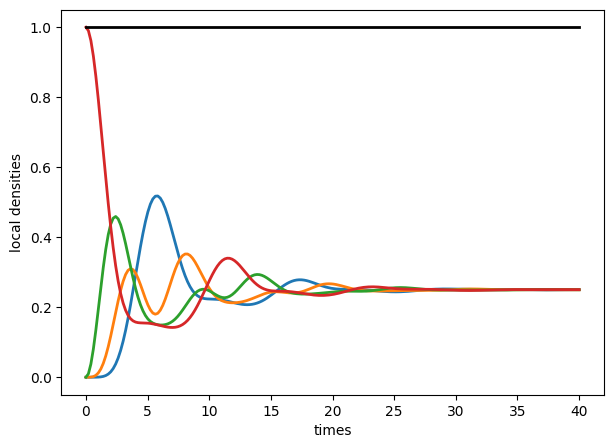

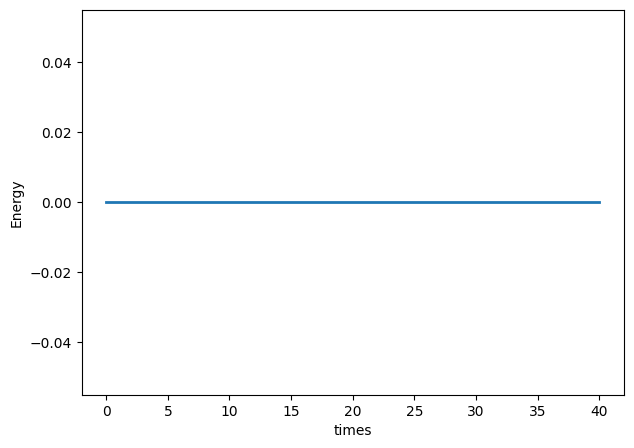

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

#plt.savefig("../plots/densities_L={}_Jc={}.pdf".format(L,J_contact))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")



Text(50.722222222222214, 0.5, 'densities')

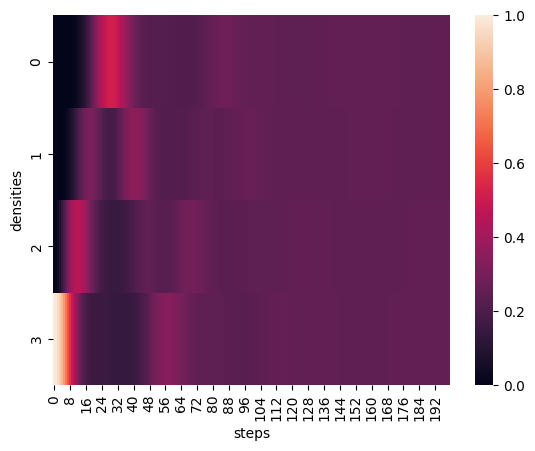

In [14]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")

#plt.savefig("../plots/trajectory_L={}_Jc={}.png".format(L,J_contact), dpi=300)


# With Gaussian initial state

(0.9999999999999994-8.11166395894001e-20j)


(-0.5, 1.1)

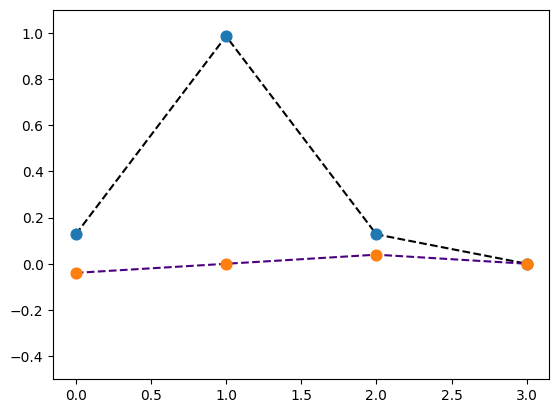

In [3]:
L = 4 # Num of sites
D = 2 # local hilbert space dimension
gamma = 0.1 # the dephasing term for the collapse operators
max_t = 30 # maximum time
tsteps = 300 # number of time steps
J = np.ones(L) # interaction
J_contact = 0.5
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"

centered_in = 1 # which site the gaussian wave packet is centered at
band_width = 0.5 # bandwidth og wave packet. Higher number means less localized
b = destroy(2) # annihilation operator
K0 = 2.0 # initial velocity of the wave packet this does not matter here i think

initial_conditions = gen_gauss_init(centered_in,band_width, L,k0=0.3)
mag = np.dot(initial_conditions,initial_conditions)
initial_conditions = initial_conditions/np.sqrt(mag)
print(np.dot(initial_conditions,initial_conditions))

plt.plot()
plt.scatter(range(0,L),initial_conditions.real, zorder=7, s=60)
plt.plot(range(0,L),initial_conditions.real, c='black', linestyle='dashed')

plt.scatter(range(0,L),initial_conditions.imag, zorder=7, s=60)
plt.plot(range(0,L),initial_conditions.imag, c='indigo', linestyle='dashed')

plt.ylim(-0.5,1.1)


# plt.savefig("../plots/initial_state_sig={}.pdf".format(band_width))



In [4]:
# initialize initial gaussian state
psi0 = gen_psi0(initial_conditions, L)
rho = ket2dm(psi0)

print(psi0.dag()*psi0)


(1+0j)


In [5]:
# create fermion operators
c_list = create_fermion_op(L)

# create the hamiltonian in terms of the fermion operators
ident_tensor = tensor([identity(D)]*L) 
H = 0*ident_tensor

for site_j in range(0,L-1):
    H += -0.5*J[site_j]*(c_list[site_j].dag()*c_list[site_j+1]+c_list[site_j+1].dag()*c_list[site_j] )

collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)


In [6]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00017690658569335938
    preparation time: 0.010740995407104492
    run time: 0.17098212242126465
    solver: 'Master Equation Evolution'
    num_collapse: 4
  Time interval: [0.0, 30.0] (300 steps)
  Number of e_ops: 5
  State not saved.
>

Text(0, 0.5, 'Energy')

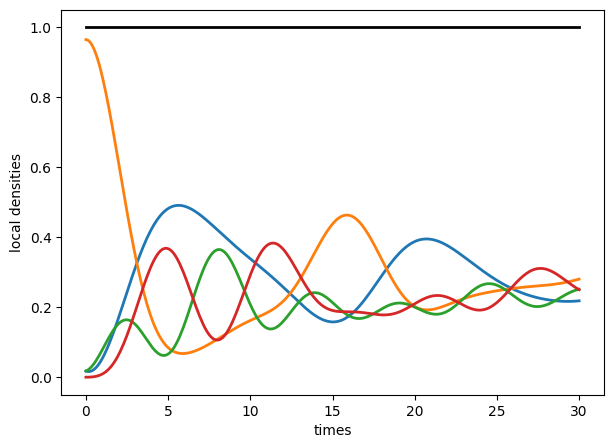

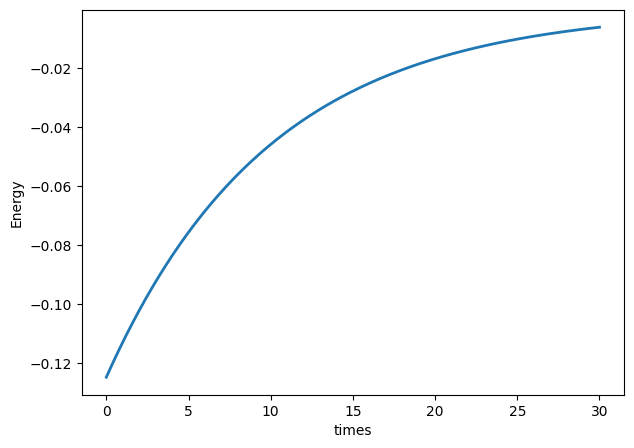

In [7]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities remember that at -1 we have the energy
n_tot = np.sum(result.expect[:-1], axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

plt.savefig("../plots/densities_L={}_Jc={}_bw={}.pdf".format(L,J_contact,band_width))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")



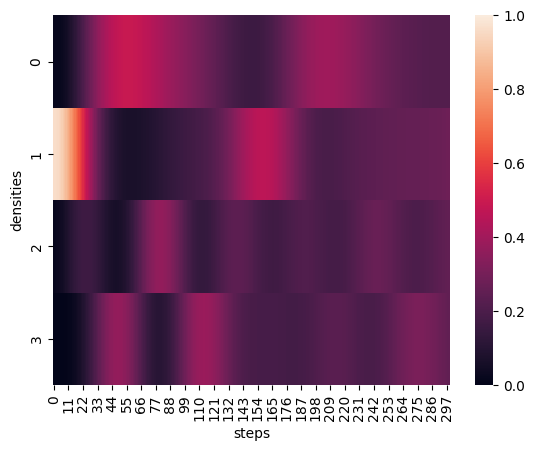

In [8]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1], vmin=0, vmax=1)
ax.set_xlabel("steps")
ax.set_ylabel("densities")

plt.savefig("../plots/trajectories_L={}_Jc={}_bw={}.png".format(L,J_contact,band_width))
